In [1]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch as t
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import re
from einops import rearrange
from tqdm.notebook import tqdm_notebook

from my_transformer import TransformerConfig, DecoderOnlyTransformer

In [3]:
with open("100-0.txt", encoding="utf-8") as file:
    text = file.read()
    words = re.split(r"\b", text)

class WordsDataset(Dataset):
    def __init__(self, words, seq_len, fraction):
        """
        `fraction` is so we can scale down the amount of training that we do (otherwise it's a big dataset!). 
        
        This parameter will change the total length, and hence changes epoch duration (from hours to minutes).
        """
        self.fraction = fraction
        self.seq_len = seq_len
        self.words = words
        # Max len is less than # words, because we need to take a slice of tokens for getitem
        self.max_len = len(self.words) - (self.seq_len + 1)
        self.vocab_size = len(set(words))
        self.words_to_token_idx = {word: idx for (idx, word) in enumerate(sorted(set(words)))}
        self.token_idx_to_words = {idx: word for (word, idx) in self.words_to_token_idx.items()}
        self.tokens = t.tensor([self.words_to_token_idx[word] for word in words]).to(dtype=t.long)

    def __len__(self):
        return int(self.max_len * self.fraction)

    def __getitem__(self, idx):
        # Given tokens (t_1, ..., t_n), we want to predict (t_2, ..., t_n+1)
        # This is actually n separate instances of task "predict j+1th token from first j tokens", for 1<=j<=n
        x_and_y = self.tokens[idx: idx + self.seq_len + 1]
        x = x_and_y[:-1]
        y = x_and_y[1:]
        return x, y

In [4]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
max_seq_len = 48
batch_size = 32

trainset = WordsDataset(words=words, seq_len=max_seq_len, fraction=0.02)
trainloader = DataLoader(trainset, shuffle=True, pin_memory=True, batch_size=batch_size)

In [6]:
config = TransformerConfig(
    num_layers = 8,
    num_heads = 8,
    vocab_size = trainset.vocab_size,
    hidden_size = 512,
    max_seq_len = trainset.seq_len,
    dropout = 0.1,
    layer_norm_epsilon = 1e-05
)

model = DecoderOnlyTransformer(config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []

In [7]:
NUM_EPOCHS = 1

model.train()
for epoch in tqdm_notebook(range(1, NUM_EPOCHS + 1)):
    inner_bar = tqdm_notebook(trainloader)
    for inputs, targets in tqdm_notebook(trainloader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        loss = criterion(
            rearrange(outputs, 'batch seq vocab -> (batch seq) vocab'),
            rearrange(targets, 'batch seq -> (batch seq)'),
        )
        train_losses.append(loss.item())
        inner_bar.set_description(f'loss = {loss.item() :.4f}')

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

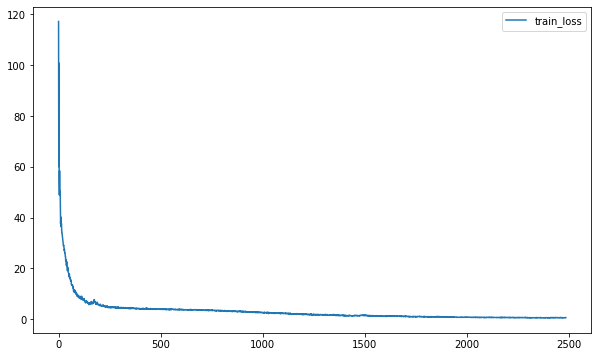

In [8]:
pd.DataFrame(train_losses, columns=['train_loss']).plot(figsize=(10, 6));

In [26]:
import my_utils
from typing import Optional, Union

class WordsTokenizer():
    def __init__(self, wordsdataset: WordsDataset):
        self.words_to_token_idx = wordsdataset.words_to_token_idx
        self.token_idx_to_words = wordsdataset.token_idx_to_words

    def encode(self, initial_text: str, return_tensors: Optional[str] = None) -> Union[list, t.Tensor]:
        list_of_strings = [s for s in re.split(r"\b", initial_text) if len(s) > 0]
        tensors_list = [self.words_to_token_idx[s] for s in list_of_strings]
        if return_tensors is None:
            return tensors_list
        elif return_tensors == "pt":
            return t.tensor(tensors_list)
        else:
            raise Exception("Unexpected value for `return_tensors`.")

    def decode(self, list_of_ids: Union[t.Tensor, list]) -> str:
        return ''.join([self.token_idx_to_words[int(token)] for token in list_of_ids])

tokenizer = WordsTokenizer(trainset)

In [44]:
initial_text = "turn down for what"

text_output = my_utils.sample_tokens(model, tokenizer, initial_text, max_tokens_generated=40, temperature=1.0, top_k=10)

print(text_output)

turn down for what right, and will quicklier be blown up; marry, in
blowing him
admiringly, nor he will the Countess
Grows of the
